In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, roc_curve, roc_auc_score

In [2]:
DATA_PATH = 'Data/'
MODEL_PREDICTIONS_PATH = 'ModelPredictions/'

EVAL_DATASET = 'test.csv'
MAX_K = 20

In [3]:
def load_csv(path, header=0, sep=','):
    df = pd.read_csv(
        path,
        sep=sep,
        keep_default_na=False,
        na_values=[""],
        index_col=False,
        header=header,
    )
    print('--- Loaded %d records from %s' % (len(df), path))
    return df

In [4]:
class MovieVocab(object):
    def __init__(self, data_path, do_lowercase):
        self.do_lowercase = do_lowercase
        df = load_csv(data_path)
        df['asin_normalized'] = df.asin.apply(self._normalize_movie)
        df = df.drop(columns=['asin'])
        df = df.rename(columns={'asin_normalized': 'asin'})        
        self.idx2movie = df.asin.unique()        
        self.movie2idx = dict()
        for idx, movie in enumerate(self.idx2movie):
            self.movie2idx[movie] = idx
        assert len(self.idx2movie) == len(self.movie2idx)
        print('--- Found %d unique movie IDs' % len(self))
    
    def _normalize_movie(self, x):
        if self.do_lowercase:
            return x.lower()
        else:
            return x
    
    def __getitem__(self, movie):
        return self.movie2idx[movie]

    def get_movie_idx_df(self, df, input_column, output_column):
        df_removed = df[~df[input_column].apply(self._normalize_movie).isin(self.idx2movie)]
        if len(df_removed) > 0:
            print('--- WARNING: Filtered out %d items (%d unique movie IDs) with unknown movie ID' % (
                len(df_removed),
                len(df_removed[input_column].unique()),
            ))   
        df = df[df[input_column].apply(self._normalize_movie).isin(self.idx2movie)].copy()            
        df[output_column] = df[input_column].apply(lambda x: self.movie2idx[self._normalize_movie(x)])
        return df              
        
    def __len__(self):
        return len(self.idx2movie)

movie_vocab = MovieVocab(os.path.join(DATA_PATH, EVAL_DATASET), True)

# --- Loaded 46359 records from Data/test.csv
# --- Found 1000 unique movie IDs

--- Loaded 46359 records from Data/test.csv
--- Found 1000 unique movie IDs


In [5]:
class TagVocab(object):
    def __init__(self, data_path):
        self.tag2idx = load_csv(data_path).set_index('tag')
        print('--- Found %d unique tags' % len(self))
        
    def __getitem__(self, tag_str):
        return self.tag2idx.tag_idx[tag_str]
        
    def __len__(self):
        return len(self.tag2idx)

    def _all_tags(self):
        return self.tag2idx.index
    
    def get_tag_idx_df(self, df, input_column, output_column):    
        df[output_column] = df[input_column].apply(lambda x: self[x])
        return df

tag_vocab = TagVocab(os.path.join(DATA_PATH, 'tags.csv'))

# --- Loaded 1128 records from Data/tags.csv
# --- Found 1128 unique tags

--- Loaded 1128 records from Data/tags.csv
--- Found 1128 unique tags


In [6]:
class MovieLens(object):
    def __init__(self, data_path, movie_vocab, tag_vocab):
        df = load_csv(data_path)
        for i, row in df.iterrows():
            assert tag_vocab[row['tag']] == row['tag_idx']
        df = movie_vocab.get_movie_idx_df(df, "asin", "movie_idx")
        self.df = df[['user', 'tag_idx', 'movie_idx']]
        self.movies = np.sort(self.df.movie_idx.unique())
        self.tags = np.sort(self.df.tag_idx.unique())
        self.score = MovieLens.compute_user_score(df, movie_vocab, tag_vocab)
        print('--- MovieLens dataset: %d records, %d unique movies, %d unique tags, %d unique users' % (
            len(self.df), len(self.movies), len(self.tags), len(self.df.user.unique())))

    @staticmethod
    def compute_user_score(df, movie_vocab, tag_vocab):
        score = np.zeros((len(movie_vocab), len(tag_vocab)))
        user_scores = (
            df
            .groupby(['movie_idx', 'tag_idx'])
            .aggregate({'user': 'count'})
            .reset_index())        
        score[user_scores.movie_idx, user_scores.tag_idx] = user_scores.user
        return score
    
movielens = MovieLens(os.path.join(DATA_PATH, EVAL_DATASET), movie_vocab, tag_vocab)

# --- Loaded 46359 records from Data/test.csv
# --- MovieLens dataset: 46359 records, 1000 unique movies, 1029 unique tags, 4139 unique users

--- Loaded 46359 records from Data/test.csv
--- MovieLens dataset: 46359 records, 1000 unique movies, 1029 unique tags, 4139 unique users


In [19]:
class Model(object):
    def __init__(
        self,
        df,        
        score_column,
        movie_vocab,
        tag_vocab,
        tag_column=None,
        tag_idx_column=None,
        default_value=0,
    ):
        assert bool(tag_column) ^ bool(tag_idx_column)
        print('--- Applying Movie Vocab')
        df = movie_vocab.get_movie_idx_df(df, 'asin', "movie_idx")
        if tag_column is not None:
            print('--- Applying Tag Vocab')            
            df = tag_vocab.get_tag_idx_df(df, tag_column, 'tag_idx')
        self.movies = np.sort(df.movie_idx.unique())
        self.tags = np.sort(df.tag_idx.unique())
        print('--- %d movies, %d tags' % (len(self.movies), len(self.tags)))
        print('--- Creating scores matrix')
        self.score = np.full(
            (len(movie_vocab), len(tag_vocab)), default_value, dtype=np.float32)
        print('--- Building scores matrix')        
        self.score[df.movie_idx, df.tag_idx] = df[score_column]
        print(
            '-- Created a model with %d predictions. '
            'Missing predictions for %d (movie, tag) pairs are using the value %.5f' % (
                len(df),
                len(movie_vocab) * len(tag_vocab) - len(df),
                default_value,
            )
        )

genome_model = Model(
    df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'tag_genome.csv')),
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
    score_column='relevance',
    tag_idx_column='tag_idx',
)

# --- Loaded 8875104 records from ModelPredictions/tag_genome.csv
# --- Applying Movie Vocab
# --- WARNING: Filtered out 7747104 items (6868 unique movie IDs) with unknown movie ID
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000

--- Loaded 8875104 records from ModelPredictions/tag_genome.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 7747104 items (6868 unique movie IDs) with unknown movie ID
--- 1000 movies, 1128 tags
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000


In [20]:
class MostPopularTagsModel(object):
    def __init__(self, data_path, movie_vocab, tag_vocab):        
        df = load_csv(data_path)
        for i, row in df.iterrows():
            assert tag_vocab[row['tag']] == row['tag_idx']
        print('--- Training data contains %d unique asins and %d unique tags' % (
            len(df.asin.unique()),
            len(df.tag.unique()),            
        ))
        users_per_tag = df.groupby('tag_idx').aggregate({'users': 'sum'}).reset_index()
        tag_frequency = np.zeros(len(tag_vocab))
        tag_frequency[users_per_tag.tag_idx] = users_per_tag.users
        tag_frequency = tag_frequency / tag_frequency.sum()
        self.movies = np.arange(len(movie_vocab))
        self.tags = np.arange(len(tag_vocab))        
        self.score = np.repeat(np.expand_dims(tag_frequency, 0), len(movie_vocab), axis=0)

most_popular_tags_model = MostPopularTagsModel(
    data_path=os.path.join(DATA_PATH, 'train.csv'),
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
)

# --- Loaded 70247 records from Data/train.csv
# --- Training data contains 12941 unique asins and 1125 unique tags

--- Loaded 70247 records from Data/train.csv
--- Training data contains 12941 unique asins and 1125 unique tags


In [32]:
# your_model = Model(
#     df=load_csv(PATH_TO_YOUR_MODEL_PREDICITIONS_CSV_FILE),
#     movie_vocab=movie_vocab,
#     tag_vocab=tag_vocab,
#     score_column=NAME_OF_THE_COLUMN_WITH_SCORES,

#     USE ONLY ONE OF THE FOLLOWING ARGUMENTS

#     tag_column=NAME_OF_THE_COLUMN_WITH_TAG,
#     tag_idx_column=NAME_OF_THE_COLUMN_WITH_TAG_IDX,
# )

docent_models = {
    'DOCENT-Full': Model(
        df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_full.csv')),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score_0',
        tag_idx_column='tag_idx',    
    ),
    'DOCENT-Dual': Model(
        df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_dual.csv')),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='relevance',
        tag_idx_column='tag_idx',    
    ),
    'DOCENT-Hybrid': Model(
        df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_hybrid.csv')), 
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='relevance',
        tag_idx_column='tag_idx',    
    ),    
    'bos_bert': Model(
        df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'bos_bert.csv')), 
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score_0',
        tag_idx_column='tag_idx',   
        default_value=-100000,
    ),
    'tf_idf': Model(
        df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'tf_idf.csv')), 
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score',
        tag_column='tag',   
        default_value=-1,
    )      
}


# --- Loaded 1128192 records from ModelPredictions/docent_full.csv
# --- Applying Movie Vocab
# --- WARNING: Filtered out 192 items (1 unique movie IDs) with unknown movie ID
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000
# --- Loaded 1128000 records from ModelPredictions/docent_dual.csv
# --- Applying Movie Vocab
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000
# --- Loaded 1128000 records from ModelPredictions/docent_hybrid.csv
# --- Applying Movie Vocab
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000
# --- Loaded 1128000 records from ModelPredictions/bos_bert.csv
# --- Applying Movie Vocab
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value -100000.00000
# --- Loaded 2695480 records from ModelPredictions/tf_idf.csv
# --- Applying Movie Vocab
# --- WARNING: Filtered out 2509214 items (36632 unique movie IDs) with unknown movie ID
# --- Applying Tag Vocab
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 186266 predictions. Missing predictions for 941734 (movie, tag) pairs are using the value -1.00000

--- Loaded 1128192 records from ModelPredictions/docent_full.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 192 items (1 unique movie IDs) with unknown movie ID
--- 1000 movies, 1128 tags
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000
--- Loaded 1128000 records from ModelPredictions/docent_dual.csv
--- Applying Movie Vocab
--- 1000 movies, 1128 tags
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000
--- Loaded 1128000 records from ModelPredictions/docent_hybrid.csv
--- Applying Movie Vocab
--- 1000 movies, 1128 tags
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 1128000 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000
--- Loaded 1128000 records from ModelPredictions/bos

In [33]:
def intersect_movie_and_tags(models, movies=None, tags=None):
    if movies is None:
        movies = np.arange(len(movie_vocab))
    else:
        movies = np.intersect1d(movies, movielens.movies)
  
    if tags is None:
        tags = np.arange(len(tag_vocab))
    else:
        tags = np.intersect1d(tags, movielens.tags)

    for name, model in models.items():
        movies = np.intersect1d(movies, model.movies)
        if name == 'tf_idf':
            # Don't filter TAGS for TF-IDF model
            continue
        tags = np.intersect1d(tags, model.tags)
    
    print('--- Movies %d, Tags %d' % (len(movies), len(tags)))
    return movies, tags

def precision_at_k(binary_labels, num_labels_per_movie, sorted_predictions):
    num_movies = len(num_labels_per_movie)
    counter, precision = np.zeros((num_movies, MAX_K)), np.zeros((num_movies, MAX_K))
    prediction_labels = np.take_along_axis(binary_labels, sorted_predictions, axis=1)
  
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(len(num_labels_per_movie)):
            if k <= num_labels_per_movie[i]:
                precision[i, k_idx] = prediction_labels[i, :k].mean()
                counter[i, k_idx] = 1
    return precision.sum(axis=0) / (counter.sum(axis=0) + 1e-8)

def set_intersection_at_k(sorted_labels, num_labels_per_movie, sorted_predictions):
    num_movies = len(num_labels_per_movie)
    counter, set_intersection = np.zeros((num_movies, MAX_K)), np.zeros((num_movies, MAX_K))
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(num_movies):
            if k <= num_labels_per_movie[i]:
                set_intersection[i, k_idx] = (
                    len(np.intersect1d(sorted_labels[i, :k], sorted_predictions[i, :k]))
                    / float(k))
                counter[i, k_idx] = 1
    return set_intersection.sum(axis=0) / (counter.sum(axis=0) + 1e-8)
    
def dcg_at_k_per_movie(labels, predictions, use_log_for_user_counts):
    num_movies = labels.shape[0]
    dcg = np.zeros((num_movies, MAX_K))
    discounts = np.log2(np.arange(2, MAX_K + 2))
    for i in range(num_movies):
        gain = labels[i, predictions[i]]
        if use_log_for_user_counts:
            gain = np.log(gain + 1)        
        for k_idx in range(MAX_K):
            k = k_idx + 1
            dcg[i, k_idx] = np.sum(gain[:k] / discounts[:k])
    return dcg

def ndcg_at_k(labels, predictions, use_log_for_user_counts):
    actual_dcg = dcg_at_k_per_movie(labels, predictions, use_log_for_user_counts)
    ideal_predicitons = np.argsort(-labels, axis=1)
    ideal_dcg = dcg_at_k_per_movie(labels, ideal_predicitons, use_log_for_user_counts)
    ndcg = actual_dcg / (ideal_dcg + 1e-8)
    return ndcg.mean(axis=0)

def compute_num_movies_at_k(num_labels_per_movie):
    num_movies = len(num_labels_per_movie)
    num_movies_at_k = np.zeros(MAX_K)
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(num_movies):
            if k <= num_labels_per_movie[i]:
                num_movies_at_k[k_idx] += 1
    return num_movies_at_k

def eval_model(
    models,
    labels=None,
    groundtruth_threshold=0,
):
    movies, tags = intersect_movie_and_tags(models, movies=None, tags=None)
    assert len(movies) > 0
    assert len(tags) > 0  

    if labels is None:
        labels = movielens.score[movies][:, tags]
    else:
        labels = labels[movies][:, tags]

    labels_flattened = (labels > groundtruth_threshold).reshape(-1)
    binary_labels = labels > groundtruth_threshold
    num_labels_per_movie = binary_labels.sum(axis=1)
    sorted_labels = np.argsort(-movielens.score[movies][:, tags], axis=1)
    movies_with_non_empty_labels = ((labels > groundtruth_threshold).sum(axis=1) > 0)
    num_movies_with_empty_labels = len(movies) - movies_with_non_empty_labels.sum()
    if num_movies_with_empty_labels > 0:
        print('--- WARNING: There are %d movies without any labels (tags): %s' % (
            num_movies_with_empty_labels,
            ','.join([str(i) for i, v in enumerate(movies_with_non_empty_labels) if v == 0])
        ))

    results = {}
    for name, model in models.items():  
        print('--- Model %s' % name)
        scores = model.score[movies][:, tags] 
        scores_flattened = scores.reshape(-1)      

        predictions = np.argsort(-scores, axis=1)
        result = {}
        result["precision@k"] = precision_at_k(
            binary_labels[movies_with_non_empty_labels],
            num_labels_per_movie[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
        )
        result["set_intersection@k"] = set_intersection_at_k(
            sorted_labels[movies_with_non_empty_labels],
            num_labels_per_movie[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
        )
        result["label_ranking_loss"] = label_ranking_loss(
            binary_labels[movies_with_non_empty_labels] > 0,
            scores[movies_with_non_empty_labels],
        )
        result["mean_average_precision"] = label_ranking_average_precision_score(
            binary_labels[movies_with_non_empty_labels] > 0,
            scores[movies_with_non_empty_labels],
        )
        result["ndcg_log@k"] = ndcg_at_k(
            labels[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
            True,
        )
        result["ndcg@k"] = ndcg_at_k(
            labels[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
            False,
        )
        result["num_movies@k"] = compute_num_movies_at_k(num_labels_per_movie)
        fpr, tpr, _ = roc_curve(labels_flattened, scores_flattened)
        result["fpr"] = fpr
        result["tpr"] = tpr
        result["auc"] = roc_auc_score(labels_flattened, scores_flattened)

        results[name] = result

    return results, movies, tags

In [34]:
models = {
    'TagGenome': genome_model,
    'MostPopularTags': most_popular_tags_model,
}
models.update(docent_models)

results_movie_heldout, _, _ = eval_model(
    models=models,
    groundtruth_threshold=1,
)

--- Movies 969, Tags 1128
--- WARNING: There are 249 movies without any labels (tags): 83,103,146,176,255,259,268,269,272,319,333,336,342,364,375,392,394,395,398,399,400,406,418,425,445,461,469,471,495,499,503,513,522,523,530,542,557,558,566,567,579,580,590,595,600,602,604,613,621,628,641,646,649,650,651,656,659,661,663,666,668,669,671,672,673,675,676,677,678,679,681,682,683,684,685,686,689,690,691,692,693,694,695,696,697,698,699,700,701,705,706,707,708,709,710,711,712,714,715,716,718,719,720,722,723,725,726,727,728,729,731,732,734,735,737,738,739,741,742,743,744,745,746,750,751,752,754,755,756,757,760,761,762,763,764,765,766,769,770,771,772,773,774,775,776,777,778,779,782,783,784,785,786,787,788,791,792,795,796,797,799,803,804,809,810,812,813,816,818,822,823,824,825,827,828,831,832,833,834,836,837,838,839,841,842,844,846,847,850,852,853,855,856,859,860,865,866,868,870,871,872,874,879,881,882,884,886,891,893,894,896,897,901,902,905,911,915,918,921,924,926,927,931,932,933,934,936,939,94

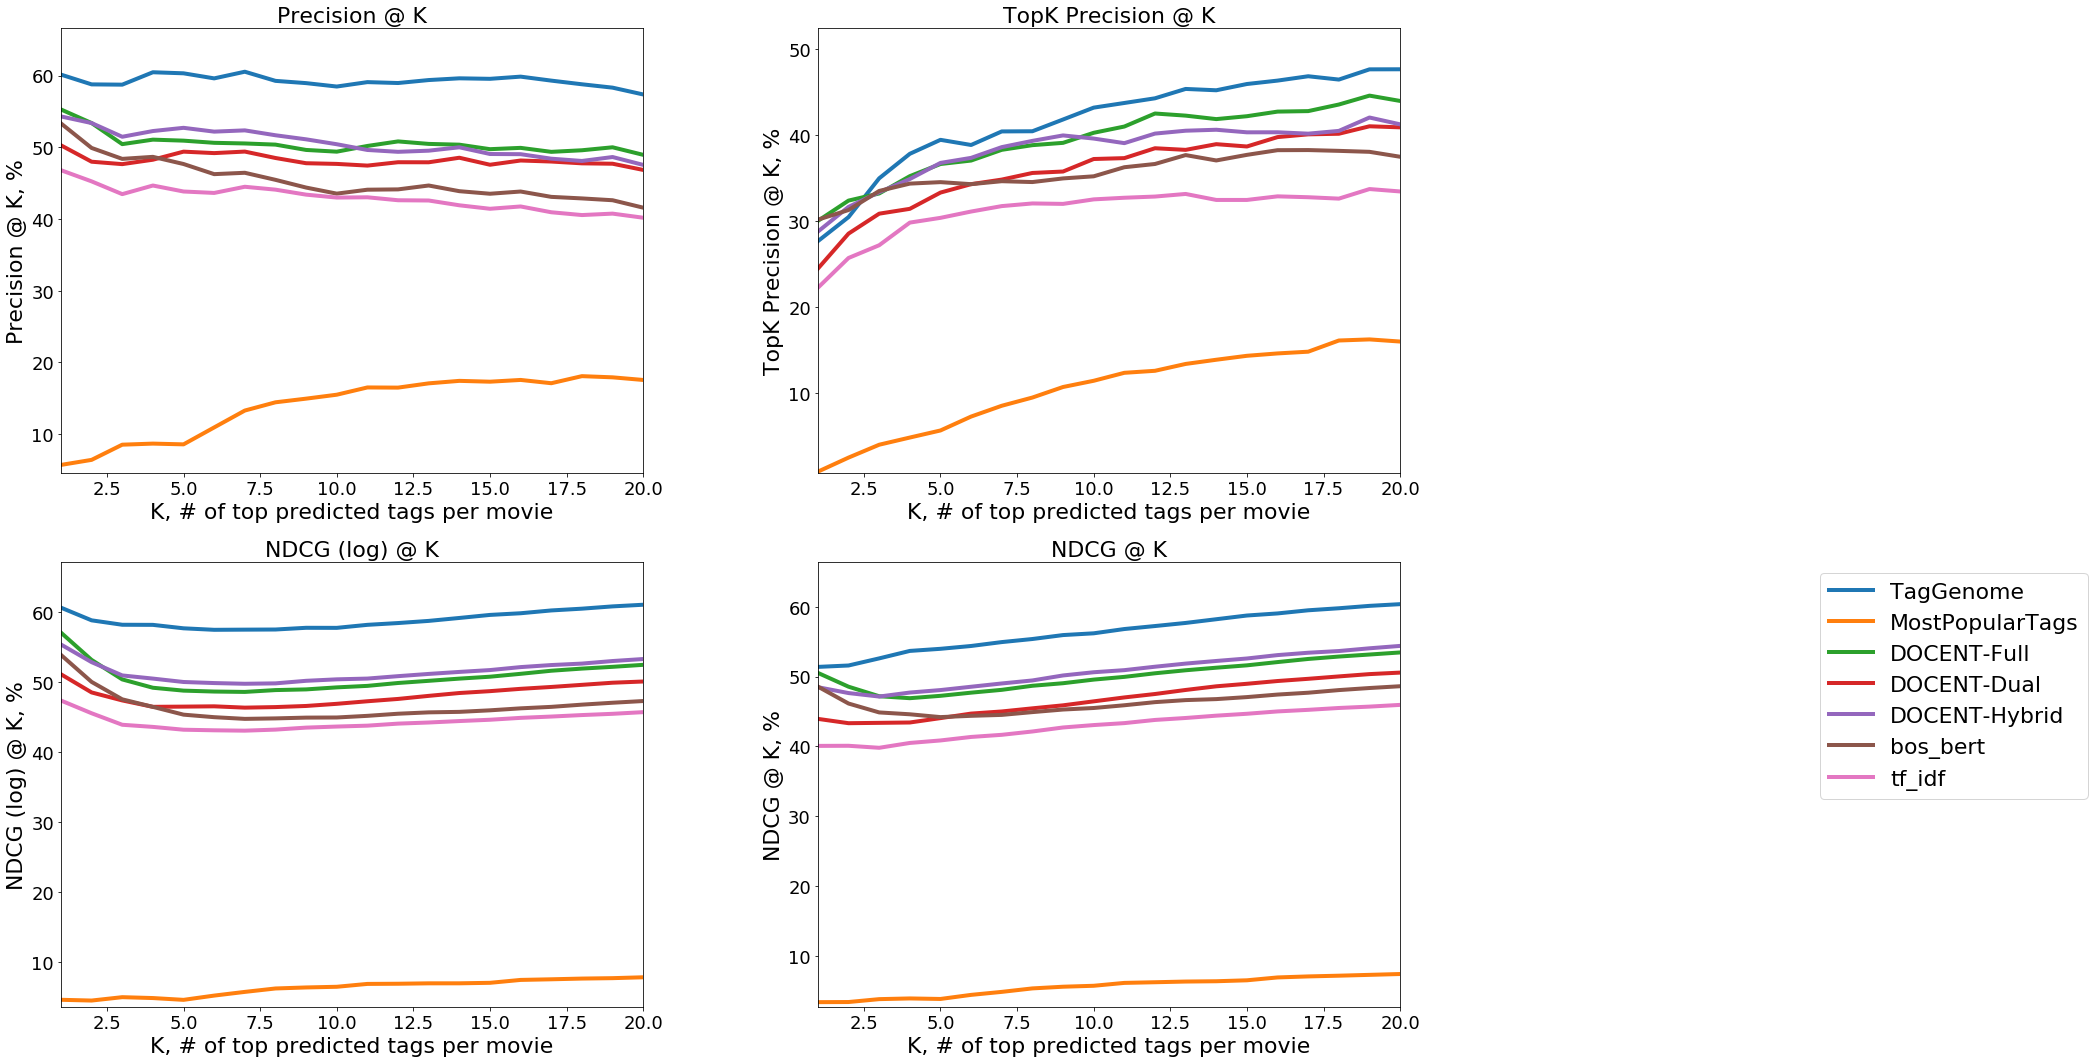

In [35]:
METRIC_LABELS = {
    'precision@k': 'Precision @ K',
    'set_intersection@k': 'TopK Precision @ K',
    'ndcg_log@k': 'NDCG (log) @ K',
    'ndcg@k': 'NDCG @ K',
#     'num_movies@k': 'Num Movies @ K',
}

def plot_ranking_results(results):  
    ALL_METRICS = METRIC_LABELS.keys()
    krange = np.arange(1, MAX_K + 1)
    plt.figure(figsize=(24, 18))#, dpi=400)

    for i, metric in enumerate(ALL_METRICS):
        ax = plt.subplot(2, 2, i + 1)
        y_min = min([result[metric].min() for _, result in results.items()])
        y_max = max([result[metric].max() for _, result in results.items()])
        plt.ylim(y_min * 80, y_max * 110)
        plt.xlim(1, MAX_K)
        for name, result in results.items():
            ax.plot(krange, result[metric] * 100.0, label=name, linewidth=4)
            
        plt.title(METRIC_LABELS[metric], fontsize=22)
        plt.ylabel(METRIC_LABELS[metric] + ', %', fontsize=22)
        plt.xlabel('K, # of top predicted tags per movie', fontsize=22)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(18)
  
    plt.legend(loc='upper right', bbox_to_anchor=(2.2, 1), fontsize=22)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

plot_ranking_results(results_movie_heldout)

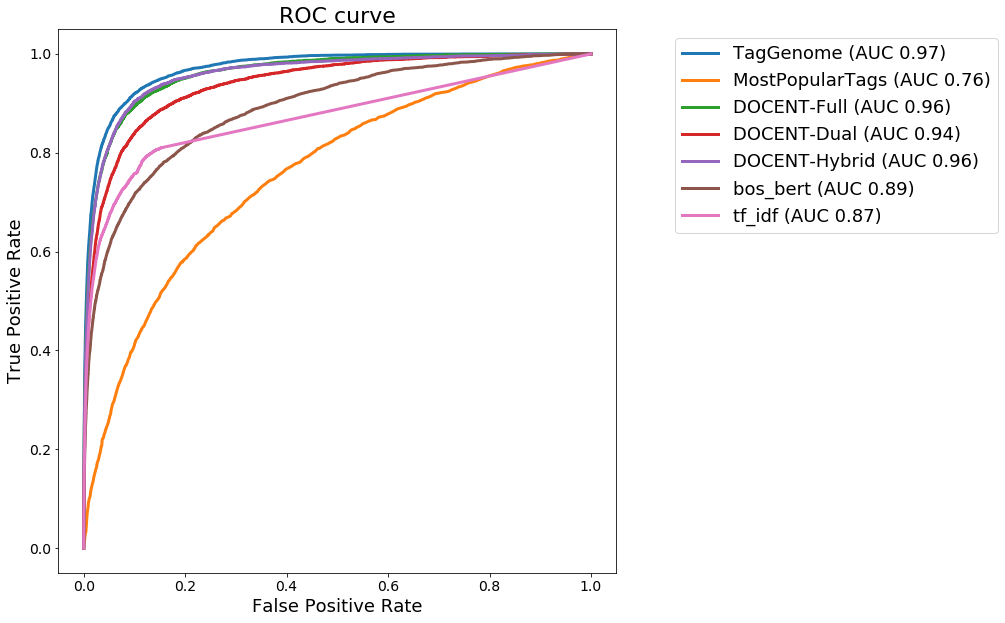

In [36]:
def plot_binary_results(results):    
    plt.figure(figsize=(10, 10))#, dpi=400)
    ax = plt.subplot(1, 1, 1)
    for name, result in results.items():
        if "fpr" in result and "tpr" in result:
            ax.plot(result["fpr"], result["tpr"], label='%s (AUC %.2f)' % (name, result["auc"]), linewidth=3)
        
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=18)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC curve', fontsize=22)
    plt.show()

plot_binary_results(results_movie_heldout)

In [37]:
class HumanScoresModel(object):
    def __init__(self, df, movie_vocab, tag_vocab):
        self.movies = np.arange(len(movie_vocab))
        self.tags = np.arange(len(tag_vocab))
        self.score = MovieLens.compute_user_score(df, movie_vocab, tag_vocab)
#         self.score /= (self.score.sum(axis=1, keepdims=True) + 1e-8)

def human_cv_eval(movielens, movie_vocab, tag_vocab, cv_num_folds, models=None, groundtruth_threshold=0):
    users = movielens.df.user.unique()
    assert cv_num_folds <= len(users)
    num_users_per_fold = int((len(users) + cv_num_folds - 1) / cv_num_folds)
    np.random.seed(31415)
    users_perm = np.random.permutation(len(users))

    all_folds_results = []
    for cv_step, i in enumerate(range(0, len(users), num_users_per_fold)):
        users_heldout = users[users_perm[i:min(i+num_users_per_fold, len(users))]]
    
        model = HumanScoresModel(
            df=movielens.df[~movielens.df.user.isin(users_heldout)].copy(),
            movie_vocab=movie_vocab,
            tag_vocab=tag_vocab,
        )
        labels = MovieLens.compute_user_score(
            movielens.df[movielens.df.user.isin(users_heldout)].copy(),
            movie_vocab=movie_vocab,
            tag_vocab=tag_vocab,
        )
        
        current_models = {
            'Human': model,
        }
        if models is not None:
            current_models.update(models)
        
        all_folds_results.append(eval_model(
            models=current_models,
            labels=labels,
            groundtruth_threshold=groundtruth_threshold)[0])
  
    models_names = ['Human']
    if models is not None:
        models_names.extend(models.keys())
    averaged_results = {}
    for model_name in models_names:
        allmetrics = set([
            metric            
            for current_fold_result in all_folds_results            
            for metric in current_fold_result[model_name].keys()

        ])    
        averaged_results[model_name] = dict()
        for metric in allmetrics:
            if metric in ["tpr", "fpr"]:
                continue
            averaged_results[model_name][metric] = np.stack([
                current_fold_result[model_name][metric]
                for current_fold_result in all_folds_results                
            ]).mean(axis=0)
    return averaged_results 

models = {
    'TagGenome': genome_model,
    'MostPopularTags': most_popular_tags_model,
}
models.update(docent_models)

results_movie_heldout_with_human = human_cv_eval(
    movielens=movielens,
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
    cv_num_folds=3,
    models=models,
    groundtruth_threshold=2,
)

--- Movies 969, Tags 1128
--- WARNING: There are 693 movies without any labels (tags): 7,13,35,37,38,50,53,57,58,65,70,83,92,93,95,103,106,107,108,110,111,112,118,119,120,122,126,130,138,140,146,148,149,150,151,152,155,157,160,168,170,173,175,176,180,181,186,188,189,190,192,194,195,204,205,206,208,209,218,219,227,231,232,235,239,241,243,244,245,249,252,254,255,256,257,259,260,261,262,265,266,267,268,269,271,272,274,277,282,283,285,288,289,290,292,293,297,298,299,300,301,306,311,312,314,315,316,317,318,319,320,321,322,324,329,331,332,333,334,335,336,337,338,340,341,342,344,345,347,349,351,352,353,355,356,357,359,361,362,363,364,366,367,368,372,374,375,376,377,379,380,381,382,383,384,385,387,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,417,418,419,420,424,425,426,427,429,430,431,432,433,435,438,439,441,442,444,445,446,448,449,450,451,453,454,455,456,458,459,460,461,462,465,466,467,468,469,470,471,472,473,474,475,476,477,479,4

--- Model TagGenome
--- Model MostPopularTags
--- Model DOCENT-Full
--- Model DOCENT-Dual
--- Model DOCENT-Hybrid
--- Model bos_bert
--- Model tf_idf


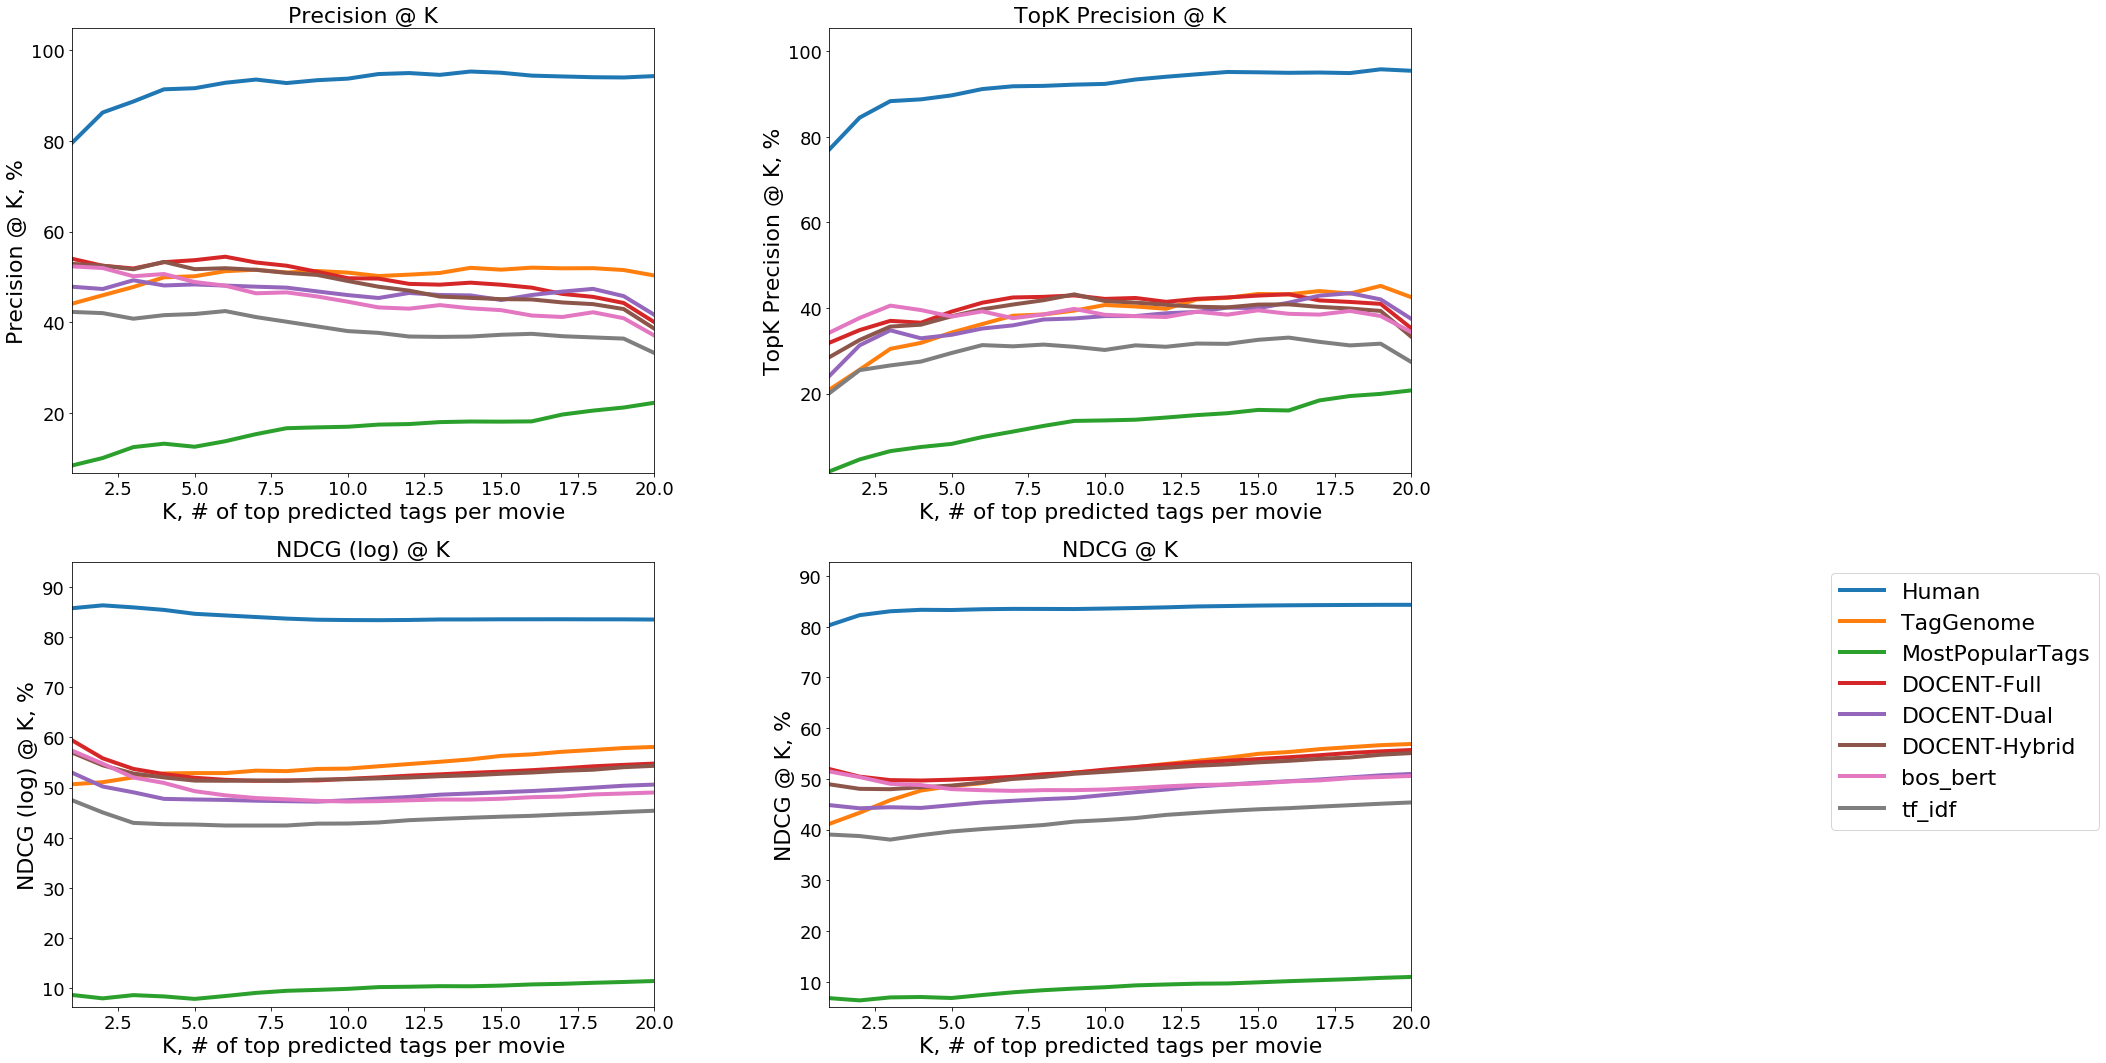

In [38]:
plot_ranking_results(results_movie_heldout_with_human)

In [40]:
print('Model\tMAP\tAUC')
print(
    '\n'.join(['%s\t%.1f\t%.2f' % (model, 100.0 * results['mean_average_precision'], results['auc']) for model, results in results_movie_heldout_with_human.items()])
)


# Model     MAP     AUC
# Human     76.5     0.99
# TagGenome     43.9     0.98
# MostPopularTags     6.2     0.80
# DOCENT-Full     44.7     0.98
# DOCENT-Dual     38.6     0.96
# DOCENT-Hybrid     44.1     0.98
# bos_bert     39.3     0.91
# tf_idf     33.3     0.90

Model	MAP	AUC
Human	76.5	0.99
TagGenome	43.9	0.98
MostPopularTags	6.2	0.80
DOCENT-Full	44.7	0.98
DOCENT-Dual	38.6	0.96
DOCENT-Hybrid	44.1	0.98
bos_bert	39.3	0.91
tf_idf	33.3	0.90


In [41]:
results_movie_heldout_with_human

{'Human': {'ndcg_log@k': array([0.85736182, 0.86308104, 0.85900901, 0.85398548, 0.84622089,
         0.84298668, 0.83983711, 0.8366543 , 0.83443963, 0.83379605,
         0.83352435, 0.83392995, 0.83492427, 0.83498246, 0.83527418,
         0.8353099 , 0.83536512, 0.83522288, 0.8351825 , 0.83476986]),
  'mean_average_precision': 0.7654644143829997,
  'num_movies@k': array([281.33333333, 206.66666667, 164.66666667, 129.        ,
         111.33333333,  95.66666667,  82.33333333,  72.        ,
          62.66666667,  54.        ,  47.33333333,  39.66666667,
          34.66666667,  29.        ,  24.66666667,  21.        ,
          17.        ,  13.        ,  10.33333333,   8.33333333]),
  'auc': 0.990686876178176,
  'precision@k': array([0.79571169, 0.86264251, 0.88687952, 0.91374466, 0.91616629,
         0.92817742, 0.9352818 , 0.92754015, 0.93386017, 0.93727106,
         0.94746377, 0.94961366, 0.94562676, 0.9529999 , 0.95030525,
         0.94393382, 0.94212391, 0.9404321 , 0.93987104, 0